# Import Packages

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
from pathlib import Path

# Setup basic configuration + define helper functions

In [ ]:
def write_to_file(file_name, content):
    with open(file_name, 'w') as f:
        f.write(content)


# Create directory for output files
Path('tmp/out').mkdir(parents=True, exist_ok=True)

# Set dark theme
plt.style.use('dark_background')

# Set grid thickness
plt.rcParams['grid.linewidth'] = 0.3

# Load Data

In [ ]:
excel_file = pd.ExcelFile("Projekt-2_Data.xlsx")
df_uloha_1: pd.DataFrame = excel_file.parse(excel_file.sheet_names[0])
df_uloha_2 = excel_file.parse(excel_file.sheet_names[1])
data = {
    '1': df_uloha_1,
    '1_a': df_uloha_1['uloha_1 a)'],
    '1_b_prior': df_uloha_1['uloha_1 b)_prior'],
    '1_g': df_uloha_1['skupina'],
    '1_b_observation': df_uloha_1['uloha_1 b)_pozorování'],
    '2': df_uloha_2,
    '2_os': df_uloha_2['OSType'],
    '2_as': df_uloha_2['ActiveUsers'],
    '2_ip': df_uloha_2['InteractingPct'],
    '2_sp': df_uloha_2['ScrollingPct'],
    '2_p': df_uloha_2['Ping [ms]'],
}
# data

# ULOHA 1 - Bayesovske odhady

## ULOHA 1.a - Konjugované apriorní a aposteriorní rozdělení, prediktivní rozdělení [2 body]

### Clean data
- Remove outliers
- Remove nan values
- Remove +-inf values
- Remove values with Z-score > 3
- Remove values with Z-score < -3

In [ ]:
df_uloha_1 = data['1_a']
# Extract observed data
observed_data = df_uloha_1.values

# remove nan or +-inf values
observed_data = observed_data[~np.isnan(observed_data)]

# Calculate Z-scores
z_scores = stats.zscore(observed_data, nan_policy='raise')

# Define a threshold for outliers (e.g., 3 standard deviations)
threshold = 3

# Filter out rows with Z-scores beyond the threshold
filtered_data = observed_data[(np.abs(z_scores) < threshold)]
filtered_data

## ULOHA 1.a.1 - Do jednoho obrázku vykreslíte apriorní a aposteriorní hustotou parametru Poissonova rozdělení $\lambda$.

In [ ]:
alpha_prior = 10  # connection count
beta_prior = 5  # time within the connection count (alpha_prior) was observed
lambda_expert = alpha_prior / beta_prior  # expert's estimate of the connection count

In [ ]:
alpha_posterior = alpha_prior + np.sum(filtered_data)
beta_posterior = beta_prior + len(filtered_data)

In [ ]:
x_prior = np.linspace(0, np.max(filtered_data), 1000)
y_prior = stats.gamma.pdf(x_prior, alpha_prior, scale=1 / beta_prior)

In [ ]:
x_posterior = np.linspace(0, np.max(filtered_data), 1000)
y_posterior = stats.gamma.pdf(x_posterior, alpha_posterior, scale=1 / beta_posterior)

In [ ]:
plt.plot(x_prior, y_prior, label='Posterior', color='blue')
plt.plot(x_posterior, y_posterior, label='Posterior', color='red')
plt.title('Prior and Posterior Distributions')
plt.xlabel('Lambda')
plt.ylabel('Probability Density')
plt.legend()
plt.show()

## ULOHA 1.a.2 - Do jednoho obrázku vykreslíte apriorní a aposteriorní prediktivní hustotou pozorovaní $x$ za jeden časový interval.

In [ ]:
x_prior_interval = range(0, 6)
y_prior_interval = stats.nbinom.pmf(x_prior_interval, alpha_prior, beta_prior / (1 + beta_prior))

In [ ]:
x_posterior_interval = range(0, 6)
y_posterior_interval = stats.nbinom.pmf(x_posterior_interval, alpha_posterior, beta_posterior / (1 + beta_posterior))

In [ ]:
plt.plot(x_prior_interval, y_prior_interval, label='Prior predictive', color='blue')
plt.plot(x_posterior_interval, y_posterior_interval, label='Prior predictive', color='red')
plt.title('Prior and Posterior Predictive densities')
plt.xlabel('How many (x) connections?')
plt.ylabel('Probability of (x) connections')
plt.legend()
plt.show()

In [ ]:
# Task 3: Construct 95% confidence intervals for λ from prior and posterior distributions
prior_ci = stats.gamma.interval(0.95, alpha_prior, scale=1 / beta_prior)
posterior_ci = stats.gamma.interval(0.95, alpha_posterior, scale=1 / beta_posterior)
print(f"Prior 95% CI: {prior_ci[0]:.5f}, {prior_ci[1]:.5f}")
print(f"Posterior 95% CI: {posterior_ci[0]:.5f}, {posterior_ci[1]:.5f}")

In [ ]:
# Task 4: Select two posterior point estimates for λ and compare them
posterior_mean = alpha_posterior / beta_posterior
posterior_mode = (alpha_posterior - 1) / beta_posterior
print(f"Aposteriori mean: {posterior_mean:.5f}")
print(f"Aposteriori mode: {posterior_mode:.5f}")

In [ ]:
# Task 5: Select one prior and one posterior point estimate for the number of observations
mu_prior = alpha_prior / beta_prior
mu_posterior = alpha_posterior / beta_posterior
print(f"Prior estimate: {mu_prior:.5f}")
print(f"Posterior estimate: {mu_posterior:.5f}")

## ULOHA 1.b - Aproximace diskrétním rozdělením [2 body]

In [ ]:
mu = 3
sigma = np.sqrt(1)
a = 1

### Load data

In [ ]:
# Cleaned data
df_uloha_1_b = {
    'prior_data': data['1_b_prior'][~np.isnan(data['1_b_prior'])],
    'observed_data': data['1_b_observation'][~np.isnan(data['1_b_observation'])],
    'group_column': data['1_g'][~np.isnan(data['1_g'])]
}
observed_data = df_uloha_1_b['observed_data']

### Uloha 1.b.1: Plot prior, posterior, and likelihood functions

In [ ]:
aprior_data_max = data['1'].groupby('skupina')['uloha_1 b)_prior'].max().reset_index()

# Získanie všetkých najväčších hodnôt do jednej dátovej sady
all_max_values = aprior_data_max['uloha_1 b)_prior']

# Určenie hraníc binov pre rovnomerné rozdelenie
all_max_values.max()
bin_width = (all_max_values.max() - all_max_values.min()) / 50
bins = np.arange(all_max_values.min(), all_max_values.max(), bin_width)

bin_height, bin_edges = np.histogram(all_max_values, bins=50)
bin_height = bin_height / np.sum(bin_height)

# Vytvorenie histogramu pre diskrétne rozdelenie
# plt.hist(all_max_values, bins=bins, edgecolor='black', alpha=0.7,density=True)
plt.bar(x=bins, height=bin_height, width=bin_width, color='blue', alpha=0.7)
plt.show()

In [ ]:
# task_1_b_cleared_data(data['1_b_prior'], data['1_b_observation'], data['1_g'])
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


def likelyhood_func(observed_data, b):
    a_truncnorm = (a - mu) / sigma
    b_truncnorm = (b - mu) / sigma
    pdf = stats.truncnorm.pdf(observed_data, a=a_truncnorm, b=b_truncnorm, loc=mu, scale=sigma)
    return pdf


likelihood = [likelyhood_func(observed_data, b_center) for b_center in bin_centers]
likelihood = np.prod(likelihood, axis=1)

likelihood_normalized = likelihood / np.sum(likelihood)
plt.bar(x=bins, height=likelihood_normalized, width=bin_width, edgecolor='black', color='red', label='Likelyhood',
        alpha=0.7)
plt.show()

In [ ]:
# Aposteriórna pst
posterior_probs = likelihood * bin_height
posterior_probs_normalized = posterior_probs / np.sum(posterior_probs)
plt.bar(bin_centers, posterior_probs_normalized, width=bin_width, edgecolor='black', color='green',
        label='Aposteriórne rozdelenie', alpha=0.7)
plt.show()

In [ ]:
# Plot apriorné rozdelenie
plt.bar(x=bins, height=bin_height, width=bin_width, color='blue', alpha=0.8, edgecolor='black')
plt.bar(bin_centers, posterior_probs_normalized, width=bin_width, edgecolor='black', color='green',
        label='Aposteriórne rozdelenie', alpha=0.8)
plt.bar(bin_centers, likelihood_normalized, width=bin_width, edgecolor='black', color='red', label='Vierohodnosť',
        alpha=0.4)
plt.show()

### Uloha 1.b.2. Z aposteriorní hustoty určete 95% interval spolehlivosti (konfidenční interval) pro parametr 𝑏.

In [ ]:
# Určení 95% intervalu spolehlivosti
cumulative_posterior = np.cumsum(posterior_probs_normalized)
lower_bound = bin_centers[np.argmax(cumulative_posterior >= 0.025)]
upper_bound = bin_centers[np.argmin(cumulative_posterior <= 0.975)]
print(f'95% Confidence Interval for Parameter b: {lower_bound:.5f}, {upper_bound:.5f}')

### Uloha 1.b.3. Vyberte dva bodové odhady parametru 𝑏 a spočítejte je.

In [ ]:
# Vybrání dvou bodových odhadů
mean = np.sum(bin_centers * posterior_probs_normalized)
median = bin_centers[np.argmax(posterior_probs_normalized)]
print(f'First point estimate: {mean:.5f}')
print(f'Second point estimate: {median:.5f}')  # Is this value OK?

# ULOHA 2 - ÚLOHA 2 – Regrese – 8. bodů

## ULOHA 2.1. [4. body] Pomocí zpětné eliminace určete vhodný regresní model. Za výchozí „plný“ model považujte plný kvadratický model (všechny interakce druhého řádu a všechny druhé mocniny, které dávají smysl).

In [421]:
# Načtení dat
df_uloha_2 = data['2']

# Předběžná analýza dat
print(df_uloha_2.head())
print(df_uloha_2.describe())

    OSType  ActiveUsers  InteractingPct  ScrollingPct  Ping [ms]
0      iOS         4113          0.8283        0.1717         47
1      iOS         7549          0.3461        0.6539         46
2  Windows         8855          0.2178        0.7822         55
3  Android         8870          0.0794        0.9206         56
4    MacOS         9559          0.7282        0.2718         76
       ActiveUsers  InteractingPct  ScrollingPct   Ping [ms]
count   502.000000      502.000000    502.000000  502.000000
mean   5485.830677        0.488613      0.511387   50.545817
std    2548.935679        0.296000      0.296000   14.797937
min     153.000000        0.000500      0.001400   11.000000
25%    3357.500000        0.229300      0.257525   40.000000
50%    5456.000000        0.482950      0.517050   52.000000
75%    7461.500000        0.742475      0.770700   60.000000
max    9953.000000        0.998600      0.999500   90.000000


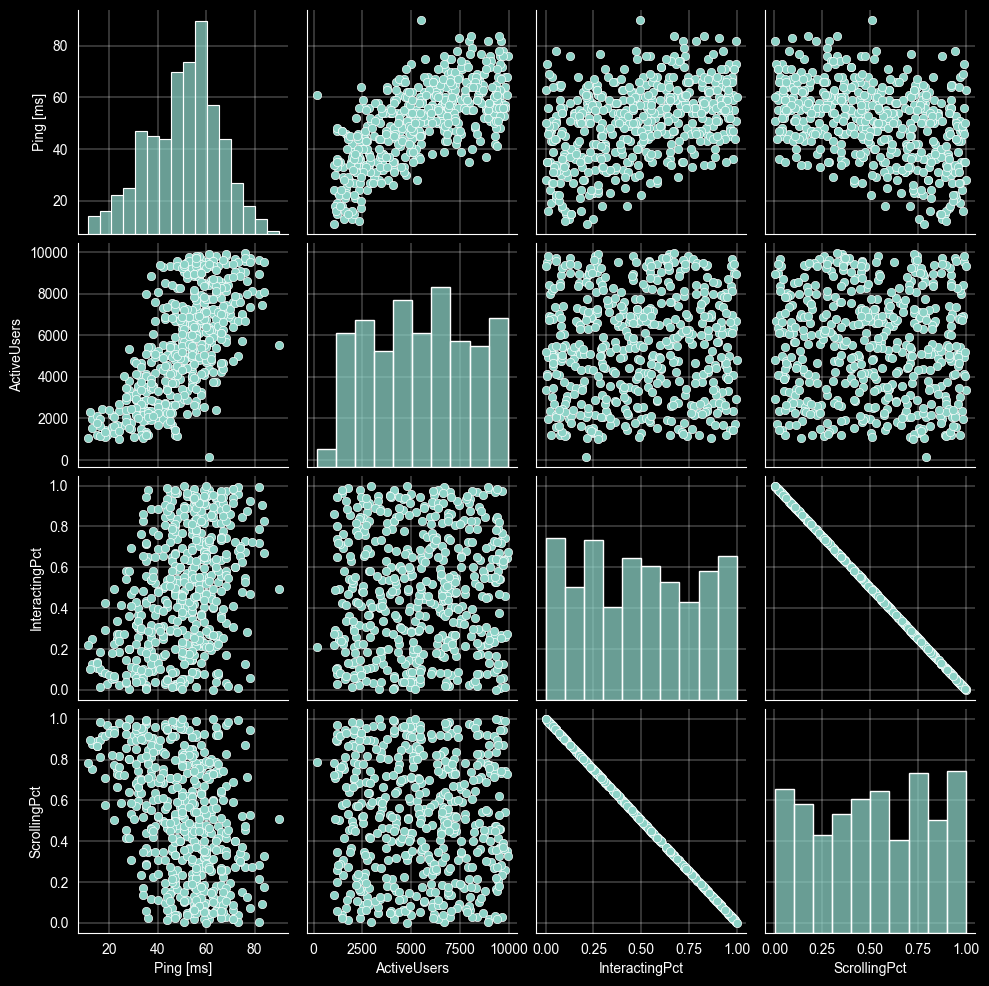

In [429]:
# Vizualizace dat
ax = sns.pairplot(df_uloha_2[['Ping [ms]', 'ActiveUsers', 'InteractingPct', 'ScrollingPct']])
plt.show()

In [450]:
# Remove correlated parameters
X = pd.DataFrame()
X['ActiveUsers'] = df_uloha_2.loc[:, 'ActiveUsers']
X['InteractingPct'] = df_uloha_2.loc[:, 'InteractingPct']
X['ScrollingPct'] = df_uloha_2.loc[:, 'ScrollingPct']
correlation_matrix = np.corrcoef(X.values.T)
corr_params = np.abs(correlation_matrix) > 0.7
# Print all correlated parameters that are not on the main diagonal and those only above main diagonal
print("Correlated parameters:")
for i in range(corr_params.shape[0]):
    for j in range(corr_params.shape[1]):
        if i != j and i < j and corr_params[i, j]:
            print(f"{X.columns[i]} - {X.columns[j]}")

print()
print("We need to remove ScrollingPct")

Correlated parameters:
InteractingPct - ScrollingPct

We need to remove ScrollingPct


In [454]:
X = pd.DataFrame()

# Base keys
X['ActiveUsers'] = df_uloha_2.loc[:, 'ActiveUsers']
X['InteractingPct'] = df_uloha_2.loc[:, 'InteractingPct']

# OS types Instead True/False values, we can use 1/0
X['Windows'] = df_uloha_2['OSType'].apply(lambda x: 1 if x == 'Windows' else 0)
X['iOS'] = df_uloha_2['OSType'].apply(lambda x: 1 if x == 'iOS' else 0)
X['MacOS'] = df_uloha_2['OSType'].apply(lambda x: 1 if x == 'MacOS' else 0)
X['Android'] = df_uloha_2['OSType'].apply(lambda x: 1 if x == 'Android' else 0)

# ActiveUsers
# X['ActiveUsers^2'] = X['ActiveUsers'] ** 2 # This is removed because of high multicollinearity
X['ActiveUsers*InteractingPct'] = X['ActiveUsers'] * X['InteractingPct']
X['ActiveUsers*OSType_windows'] = X['ActiveUsers'] * X['Windows']
X['ActiveUsers*OSType_iOS'] = X['ActiveUsers'] * X['iOS']
X['ActiveUsers*OSType_MacOS'] = X['ActiveUsers'] * X['MacOS']
X['ActiveUsers*OSType_Android'] = X['ActiveUsers'] * X['Android']

# InteractingPct
X['InteractingPct^2'] = X['InteractingPct'] ** 2
X['InteractingPct*OSType_windows'] = X['InteractingPct'] * X['Windows']
X['InteractingPct*OSType_iOS'] = X['InteractingPct'] * X['iOS']
X['InteractingPct*OSType_MacOS'] = X['InteractingPct'] * X['MacOS']
X['InteractingPct*OSType_Android'] = X['InteractingPct'] * X['Android']

# Const
X = sm.add_constant(X)  # přidání konstanty 1.0

In [455]:
def get_column_to_remove(model):
    """
    Firstly get all quadratic columns ending with ^2, then remove interaction terms and after all linear terms
    :param model: 
    :return: 
    """
    pvalues = model.pvalues
    pvalues = pvalues[pvalues > 0.05]
    pvalues = pvalues.drop('const') if 'const' in pvalues else pvalues

    # check if there is any quadratic term
    quadratic_terms = [i for i in pvalues.index if i.endswith('^2')]

    # check if there is any interaction term
    interaction_terms = [i for i in pvalues.index if '*' in i]

    # check if there is any linear term
    linear_terms = [i for i in pvalues.index if i not in quadratic_terms and i not in interaction_terms]

    if len(quadratic_terms) > 0:
        return quadratic_terms[0]
    elif len(interaction_terms) > 0:
        return interaction_terms[0]
    elif len(linear_terms) > 0:
        return linear_terms[0]
    else:
        return None

In [457]:
# Remove from X the values taht has p-value >= 0.05
y = df_uloha_2['Ping [ms]']
model = sm.OLS(endog=y, exog=X).fit()

while remove_col := get_column_to_remove(model):
    print(f"Removing {remove_col}")
    X = X.drop(remove_col, axis=1)
    model = sm.OLS(endog=y, exog=X).fit()

print(model.summary())
write_to_file('tmp/out/model_summary2.txt', model.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     239.1
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          2.27e-173
Time:                        01:39:14   Log-Likelihood:                -1642.4
No. Observations:                 502   AIC:                             3305.
Df Residuals:                     492   BIC:                             3347.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

### ULOHA 2.1.1 Zapište rovnici Vašeho finálního modelu.

In [458]:
# Rovnice
model_params = model.params.drop('const')
equation = f"ping = {model.params['const']:.5f} + "
for k, v in model_params.items():
    equation += f"{v:.5f} * {k} + \n"
print(equation)

ping = 9.60572 + 0.00457 * ActiveUsers + 
28.31469 * InteractingPct + 
8.71414 * Windows + 
-0.00329 * ActiveUsers*InteractingPct + 
0.00262 * ActiveUsers*OSType_MacOS + 
0.00091 * ActiveUsers*OSType_Android + 
7.46096 * InteractingPct*OSType_windows + 
6.09621 * InteractingPct*OSType_iOS + 
7.19836 * InteractingPct*OSType_MacOS + 
7.55917 * InteractingPct*OSType_Android + 


### ULOHA 2.1.2 Diskutujte splnění předpokladů lineární regrese a základní regresní diagnostiky.
TODO

### ULOHA 2.1.3 Pokud (až během regresního modelování) identifikujete některé „extrémně odlehlé hodnoty“ můžete ty „nejodlehlejší“ hodnoty, po alespoň krátkém zdůvodnění, vyřadit.
TODO

## ULOHA 2.2. [1. body] - Pomocí Vašeho výsledného modelu identifikujte, pro které nastavení parametrů má odezva nejproblematičtější hodnotu.

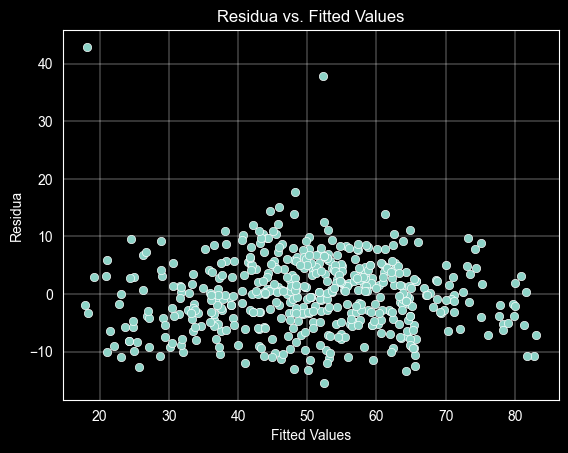

In [459]:
# Diagnostika předpokladů lineární regrese a odstranění odlehlých hodnot
# Residua vs. Fitted Values (diagnostický graf)
sns.scatterplot(x=model.fittedvalues, y=model.resid)
plt.title("Residua vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residua")
plt.show()

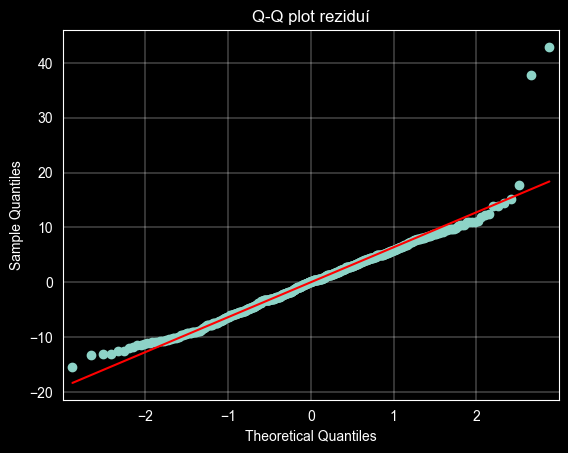

In [460]:
# Normality reziduí (Q-Q plot)
sm.qqplot(model.resid, line='s')
plt.title("Q-Q plot reziduí")
plt.show()

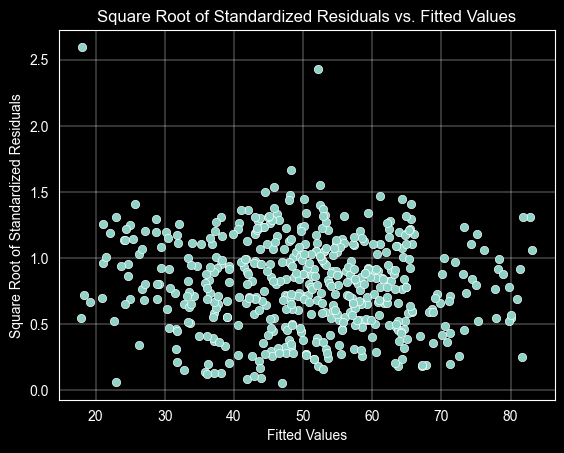

In [461]:
# Homoskedasticita (diagnostický graf)
influence = model.get_influence()
residuals_studentized = influence.resid_studentized_internal
fitted_values = model.fittedvalues
sns.scatterplot(x=fitted_values, y=np.sqrt(np.abs(residuals_studentized)))
plt.title("Square Root of Standardized Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Square Root of Standardized Residuals")
plt.show()

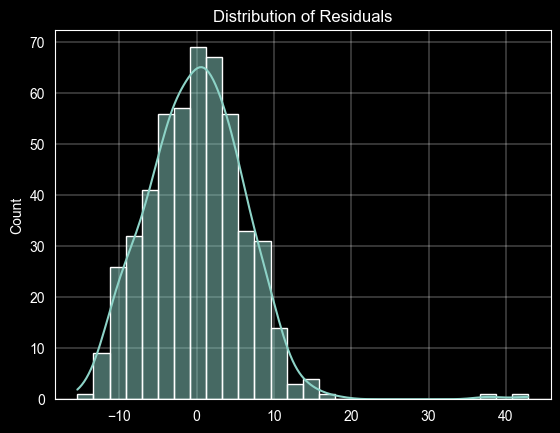

In [462]:
# Testy a diagnostika
residuals = model.resid
# residuals
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

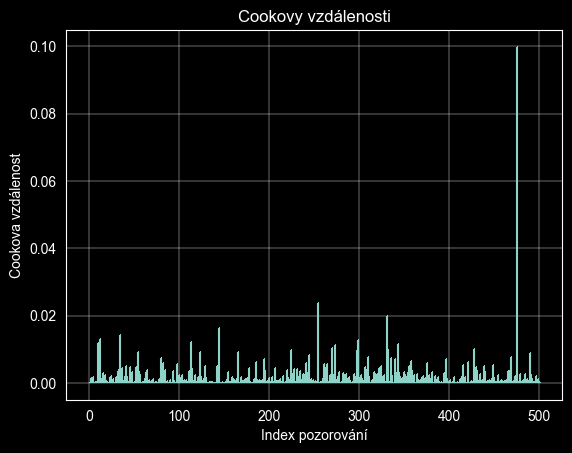

In [463]:
# Detekce odlehlých hodnot pomocí Cookovy vzdálenosti
influence = model.get_influence()
cook_distance = influence.cooks_distance
# cook_distance
plt.stem(cook_distance[0], markerfmt=",", basefmt=" ")
plt.title("Cookovy vzdálenosti")
plt.xlabel("Index pozorování")
plt.ylabel("Cookova vzdálenost")
plt.show()

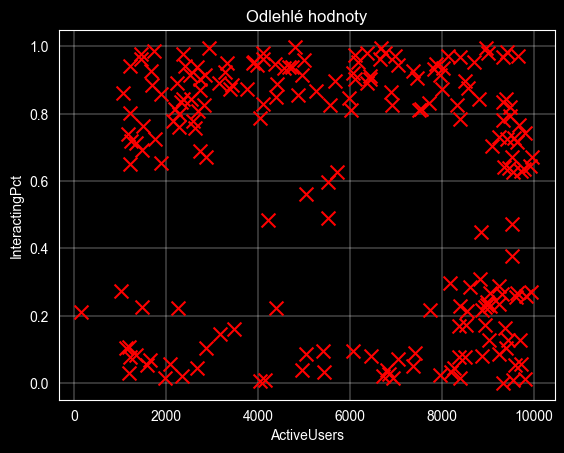

In [464]:
# Identifikace odlehlých hodnot
influence = model.get_influence()
leverage = influence.hat_matrix_diag
residuals_studentized = influence.resid_studentized_internal
outliers = np.where((np.abs(residuals_studentized) > 2) | (leverage > 0.02))
outliers

# Výpis odlehlých hodnot
plt.scatter(X.iloc[outliers[0], 1], X.iloc[outliers[0], 2], s=100, c='r', marker='x', linewidths=1.5)
plt.xlabel('ActiveUsers')
plt.ylabel('InteractingPct')
plt.title('Odlehlé hodnoty')
plt.show()

In [465]:
# Odstranění nejodlehlejších hodnot
outliers_idx = np.where(cook_distance[0] > 4 / len(y))[0]
print("Nejodlehlejší hodnoty:", outliers_idx)
X_cleaned = X.drop(outliers_idx, axis=0)
y_cleaned = y.drop(outliers_idx)

Nejodlehlejší hodnoty: [ 10  12  35  54 113 123 145 166 224 244 255 270 273 298 299 331 332 343
 428 476 490]


In [466]:
# Opětovná regrese po odstranění odlehlých hodnot
model_cleaned = sm.OLS(endog=y_cleaned, exog=sm.add_constant(X_cleaned)).fit()
print(model_cleaned.summary())
write_to_file('tmp/out/model_summary2_cleaned.txt', model_cleaned.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:              Ping [ms]   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     323.0
Date:                Fri, 15 Dec 2023   Prob (F-statistic):          3.29e-195
Time:                        01:39:25   Log-Likelihood:                -1503.7
No. Observations:                 481   AIC:                             3027.
Df Residuals:                     471   BIC:                             3069.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const         

In [467]:
vif = pd.Series([variance_inflation_factor(X.values, i) for i in range(X.shape[1])], index=X.columns)
vif

/Users/zlapik/repos/msp-project2/venv/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


const                            21.897009
ActiveUsers                       4.289210
InteractingPct                         inf
Windows                           4.764355
ActiveUsers*InteractingPct        8.679854
ActiveUsers*OSType_MacOS          3.525404
ActiveUsers*OSType_Android        3.701932
InteractingPct*OSType_windows          inf
InteractingPct*OSType_iOS              inf
InteractingPct*OSType_MacOS            inf
InteractingPct*OSType_Android          inf
dtype: float64

## ULOHA 2.3. [1. bod] - Odhadněte hodnotu odezvy uživatele s Windows, při průměrném nastavení ostatních parametrů a vypočtěte konfidenční interval a predikční interval pro toto nastavení.

In [468]:
# Průměrné hodnoty pro všechny ostatní parametry
mean_values = X.mean()
mean_values

# Vytvoření dat pro predikci (uživatel s Windows, průměrné hodnoty pro ostatní parametry)
# new_data = pd.DataFrame({
#     'ActiveUsers': mean_values['ActiveUsers'],
#     'InteractingPct': mean_values['InteractingPct'],
#     # 'ScrollingPct': mean_values['ScrollingPct'],
#     # 'InteractingPct^2': mean_values['InteractingPct^2'],
#     'Windows': 1,  # Uživatel s Windows
#     # 'iOS': mean_values['iOS'],
#     # 'MacOS': mean_values['MacOS'],
#     # 'Android': mean_values['Android'],
#     'ActiveUsers*InteractingPct': mean_values['ActiveUsers*InteractingPct'],
#     # 'ActiveUsers*OSType_windows': mean_values['ActiveUsers*OSType_windows'],
#     # 'ActiveUsers*OSType_iOS': mean_values['ActiveUsers*OSType_iOS'],
#     'ActiveUsers*OSType_MacOS': mean_values['ActiveUsers*OSType_MacOS'],
#     'ActiveUsers*OSType_Android': mean_values['ActiveUsers*OSType_Android'],
#     'InteractingPct*OSType_windows': mean_values['InteractingPct*OSType_windows'],
#     'InteractingPct*OSType_iOS': mean_values['InteractingPct*OSType_iOS'],
#     'InteractingPct*OSType_MacOS': mean_values['InteractingPct*OSType_MacOS'],
#     'InteractingPct*OSType_Android': mean_values['InteractingPct*OSType_Android'],
#     'const': 1  # Přidání konstanty pro model
# })

# Predikce odezvy
predicted_ping = model.predict(mean_values)

# Výpočet konfidenčního intervalu
confidence_interval = model.get_prediction(mean_values).conf_int()

# Výpočet predikčního intervalu
prediction_interval = model.get_prediction(mean_values).conf_int(obs=True)

# Výpis výsledků
print(f"Predikovaná odezva uživatele s Windows: {predicted_ping.values[0]:.5f}")
print("\nKonfidenční interval:")
print(confidence_interval)
print("\nPredikční interval:")
print(prediction_interval)

Predikovaná odezva uživatele s Windows: 50.54582

Konfidenční interval:
[[49.98092754 51.11070593]]

Predikční interval:
[[37.87667304 63.21496042]]


## ULOHA 2.4. [2. body] - Na základě jakýchkoli vypočtených charakteristik argumentujte, zdali je Váš model „vhodný“ pro další použití.